# Imports

In [1]:
import dolfin as dl
import hippylib as hl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from spin.core import problem
from spin.fenics import converter
from spin.hippylib import hessian, laplace, misfit, optimization, prior

sns.set_theme(style="ticks")

# PDE Problem and Data

In [2]:
# Set up 1D mesh
mesh = dl.IntervalMesh(100, -1.5, 1.5)

# Define variational PDE problem in SPIN
problem_settings = problem.SPINProblemSettings(
    mesh=mesh,
    pde_type="mean_exit_time",
    inference_type="drift_only",
    log_squared_diffusion=("std::log(std::pow(x[0],2) + 2)",),
)
problem_builder = problem.SPINProblemBuilder(problem_settings)
spin_problem = problem_builder.build()

In [3]:
# Set up ground truth
parameter_coordinates = spin_problem.coordinates_parameters
solution_coordinates = spin_problem.coordinates_variables
true_parameter = converter.create_dolfin_function(
    ("-2*std::pow(x[0],3) + 3*x[0]",), spin_problem.function_space_parameters
)
true_parameter = converter.convert_to_numpy(
    true_parameter.vector(), spin_problem.function_space_parameters
)
true_solution = spin_problem.solve_forward(true_parameter)

# Generate artificial data by perturbing the true solution
noise_std = 0.01
data_stride = 5
rng = np.random.default_rng(seed=0)
data_locations = solution_coordinates[4:-5:data_stride]
data_values = true_solution[4:-5:data_stride]
noise = rng.normal(loc=0, scale=noise_std, size=data_values.size)
data_values = data_values + noise

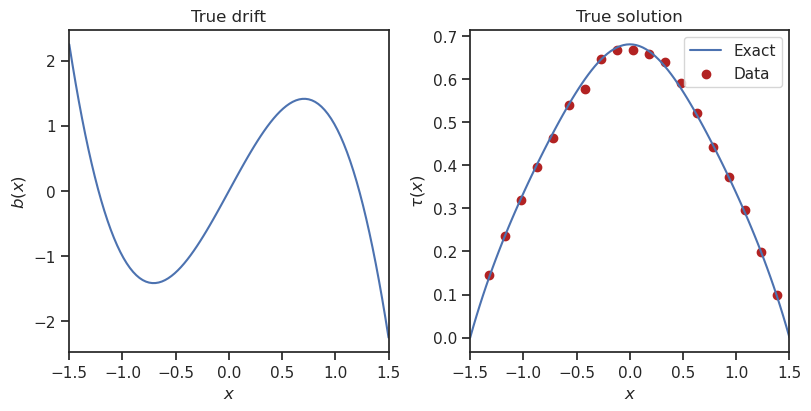

In [4]:
# Plot ground truth with data
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout="constrained")

# Parameter
axs[0].plot(parameter_coordinates, true_parameter)
axs[0].set_xlim(-1.5, 1.5)
axs[0].set_title("True drift")
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$b(x)$")

# Solution and data
axs[1].plot(solution_coordinates, true_solution, label="Exact")
axs[1].scatter(data_locations, data_values, color="firebrick", label="Data")
axs[1].set_xlim(-1.5, 1.5)
axs[1].set_title("True solution")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$\tau(x)$")
axs[1].legend()

# Prior

In [5]:
# Set up SPIN prior
prior_settings = prior.PriorSettings(
    function_space=spin_problem.function_space_parameters,
    mean=("-x[0]",),
    variance=("1",),
    correlation_length=("1",),
    robin_bc=True,
    robin_bc_const=3.0,
)
prior_builder = prior.BilaplacianVectorPriorBuilder(prior_settings)
spin_prior = prior_builder.build()
prior_variance = spin_prior.compute_variance_with_boundaries(
    method="Randomized", num_eigenvalues_randomized=50
)

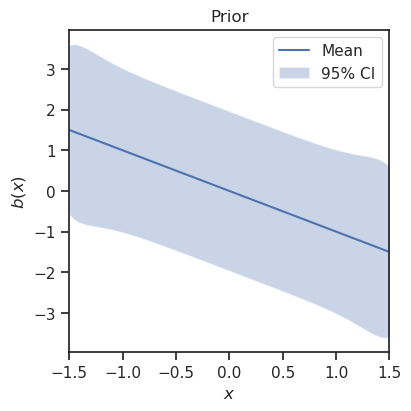

In [6]:
# Plot prior mean and variance
_, ax = plt.subplots(figsize=(4, 4), layout="constrained")
ax.plot(parameter_coordinates, spin_prior.mean_array, label="Mean")
ax.fill_between(
    parameter_coordinates.flatten(),
    spin_prior.mean_array - 1.96 * np.sqrt(prior_variance),
    spin_prior.mean_array + 1.96 * np.sqrt(prior_variance),
    alpha=0.3,
    label="95% CI",
)
ax.set_title("Prior")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$b(x)$")
ax.set_xlim(-1.5, 1.5)
ax.legend()

# Misfit and Inference Model

In [7]:
# Set up SPIN misfit
misfit_settings = misfit.MisfitSettings(
    function_space=spin_problem.function_space_variables,
    observation_points=data_locations,
    observation_values=data_values,
    noise_variance=np.ones(data_values.shape) * noise_std**2,
)
misfit_builder = misfit.MisfitBuilder(misfit_settings)
spin_misfit = misfit_builder.build()

In [8]:
# Generate hippylib model from SPIN PDE problem, prior, and misfit
inference_model = hl.Model(
    spin_problem.hippylib_variational_problem,
    spin_prior.hippylib_prior,
    spin_misfit.hippylib_misfit,
)

# Optimization

In [9]:
# Compute MAP point using Newton-CG solver
optimization_settings = optimization.SolverSettings(
    relative_tolerance=1e-8, absolute_tolerance=1e-12, verbose=True
)
initial_guess = spin_prior.mean_array
newton_solver = optimization.NewtonCGSolver(optimization_settings, inference_model)
solver_solution = newton_solver.solve(initial_guess)
print("Termination reason:", solver_solution.termination_reason)


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    1.889616e+03    1.887812e+03    1.803933e+00   -5.170915e+04   3.219192e+04   1.000000e+00   5.000000e-01
  2   1    5.076705e+01    4.661511e+01    4.151942e+00   -3.753275e+03   4.502810e+03   1.000000e+00   3.739972e-01
  3   1    1.189700e+01    7.168961e+00    4.728040e+00   -7.779092e+01   4.729717e+02   1.000000e+00   1.212116e-01
  4   4    9.256516e+00    4.326960e+00    4.929556e+00   -5.257498e+00   3.392275e+01   1.000000e+00   3.246176e-02
  5   5    9.103538e+00    4.016698e+00    5.086840e+00   -3.082656e-01   6.164694e+00   1.000000e+00   1.383829e-02
  6   6    9.101899e+00    4.011859e+00    5.090041e+00   -3.276236e-03   7.549289e-01   1.000000e+00   4.842611e-03
  7   8    9.101899e+00    4.011912e+00    5.089987e+00   -2.648287e-07   6.951740e-03   1.000000e+00   4.647007e-04
Termination reason: Norm of the gradient less than tolerance


# Low-Rank Hessian

In [10]:
# Compute low-rank Hessian approximation using randomized SVD
hessian_settings = hessian.LowRankHessianSettings(
    inference_model=inference_model,
    num_eigenvalues=15,
    num_oversampling=5,
    gauss_newton_approximation=False,
)
evaluation_point = [
    solver_solution.forward_solution,
    solver_solution.optimal_parameter,
    solver_solution.adjoint_solution,
]
eigenvalues, eigenvectors = hessian.compute_low_rank_hessian(hessian_settings, evaluation_point)

Text(0, 0.5, '$\\lambda_i$')

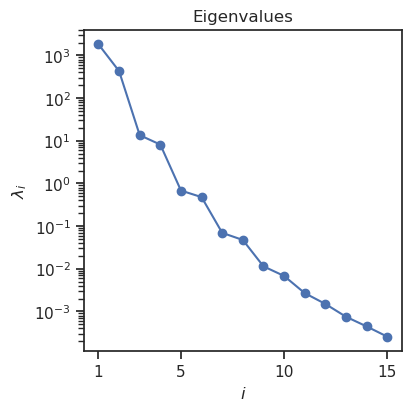

In [11]:
# Plot Hessian eigenvalues
index_vector = np.arange(1, eigenvalues.size + 1)
_, ax = plt.subplots(figsize=(4, 4), layout="constrained")
ax.semilogy(index_vector, eigenvalues, marker="o")
ax.set_title("Eigenvalues")
ax.set_xticks((1, 5, 10, 15))
ax.set_xlabel(r"$i$")
ax.set_ylabel(r"$\lambda_i$")

# Laplace Approximation

In [12]:
# Construct Laplace approximation from MAP solution and low-rank Hessian approximation
laplace_approximation_settings = laplace.LowRankLaplaceApproximationSettings(
    inference_model=inference_model,
    mean=solver_solution.optimal_parameter,
    low_rank_hessian_eigenvalues=eigenvalues,
    low_rank_hessian_eigenvectors=eigenvectors,
)
laplace_approximation = laplace.LowRankLaplaceApproximation(laplace_approximation_settings)
posterior_variance = laplace_approximation.compute_pointwise_variance(
    method="Randomized", num_eigenvalues_randomized=50
)

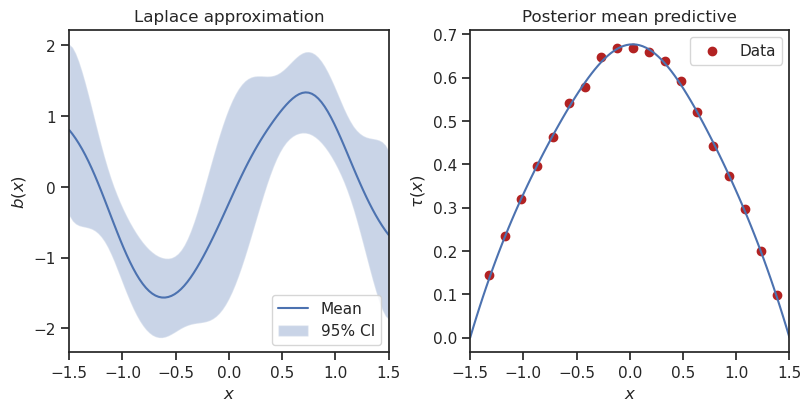

In [13]:
# Visualize Laplace approximation and posterior predictive
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout="constrained")

# Parameter
axs[0].plot(parameter_coordinates, solver_solution.optimal_parameter, label="Mean")
axs[0].fill_between(
    parameter_coordinates.flatten(),
    solver_solution.optimal_parameter - 1.96 * np.sqrt(posterior_variance),
    solver_solution.optimal_parameter + 1.96 * np.sqrt(posterior_variance),
    alpha=0.3,
    label="95% CI",
)
axs[0].set_title("Laplace approximation")
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$b(x)$")
axs[0].set_xlim((-1.5, 1.5))
axs[0].legend()

# Forward solution and data
axs[1].plot(solution_coordinates, solver_solution.forward_solution)
axs[1].scatter(data_locations, data_values, color="firebrick", label="Data")
axs[1].set_title("Posterior mean predictive")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$\tau(x)$")
axs[1].set_xlim((-1.5, 1.5))
axs[1].legend()